In [1]:
import pandas as pd
# loads X train dataset (features of each instance)
x_train = pd.read_csv('CompleteDataSet/x_train_all.csv')
# load Y train dataset (classes of each instance)
y_train=pd.read_csv('CompleteDataSet/y_train_all.csv')

x_train.shape

(9690, 2304)

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import seaborn as sns
from sklearn.metrics import silhouette_score, adjusted_rand_score
from sklearn.metrics import accuracy_score




In [3]:
# Function to get silhouette score
# takes dataframe and predicted labels as parameters
# returns silhouette score
def silhouetteScore(data, clustersdata):
    silhouette_avg = silhouette_score(data, clustersdata)
    print("Silhouette Score:", silhouette_avg)
    return silhouette_avg

### Create Diff kinds of dataframe


##### PCA

In [4]:
n_components = 1500  # Adjust this number as needed
pca = PCA(n_components=n_components)
X_pca = pca.fit_transform(x_train)

pca1000 = PCA(n_components=1000)
X_pca1000 = pca1000.fit_transform(x_train)

pca2000 = PCA(n_components=2000)
X_pca2000 = pca2000.fit_transform(x_train)

# function to apply PCA on dataframe
# returns df with PCA applied
def PCAOnData(data,components):
    pca = PCA(n_components=components)
    X_pca = pca.fit_transform(data)
    df_pca = pd.DataFrame(data=X_pca, columns=[f'PC{i+1}' for i in range(X_pca.shape[1])])
    return df_pca

##### Pre-Processed

In [5]:
processed_df = pd.read_csv('processed_df.csv')

##### Infra-Red


In [11]:
def grayscale_to_infrared(grayscale_image):
    row = np.array(grayscale_image, dtype=np.uint8)
    color_map = plt.get_cmap('hot')
    normalized_image = row / 255.0
    infrared_image = (color_map(normalized_image)[:, :, 0] * 255).astype(np.uint8)
    return infrared_image.flatten()

In [12]:
infrared_original = []

for i, idx in enumerate(x_train.index):
    original_image = x_train.iloc[idx].values.reshape(48, 48)
    infrared_image = grayscale_to_infrared(original_image)
    infrared_original.append(infrared_image)

infrared_df_org = pd.DataFrame(infrared_original)
infrared_df_org.shape

(9690, 2304)

In [13]:
infrared_df_org.to_csv("infrared_df_org.csv")

In [8]:
from sklearn.ensemble import IsolationForest

feature_names = [f'feature_{str(col)}' for col in x_train.columns]
infrared_copy = x_train.copy()
infrared_copy.columns = feature_names

contamination = 0.01
iso_forest = IsolationForest(contamination=contamination, random_state=42)

outliers = iso_forest.fit_predict(infrared_copy)

outlier_indices = infrared_copy.index[outliers == -1]

infra_no_outliers = infrared_copy.drop(outlier_indices)
infra_no_outliers.to_csv('x_train_no_outliers.csv',index=False)

outlier_indices_df = pd.DataFrame({'outlier_index': outlier_indices})

outlier_indices_df.to_csv('outlier_indices.csv', index=False)

In [9]:
y_train = pd.read_csv('CompleteDataSet/y_train_all.csv')
y_train_no_outliers = y_train.drop(outlier_indices)

In [10]:
mean=infra_no_outliers.mean()
std=infra_no_outliers.std()
infra_norm=(infra_no_outliers-mean)/std

In [11]:
mean=x_train.mean()
std=x_train.std()
x_norm=(x_train-mean)/std

In [12]:
infrared_original = []

for i, idx in enumerate(x_norm.index):
    original_image = x_norm.iloc[idx].values.reshape(48, 48)
    infrared_image = grayscale_to_infrared(original_image)
    infrared_original.append(infrared_image)

infrared_df_norm = pd.DataFrame(infrared_original)
infrared_df_norm.shape

(9690, 2304)

In [13]:
from sklearn.ensemble import IsolationForest

feature_names = [f'feature_{str(col)}' for col in infrared_df_norm.columns]
infrared_copy = infrared_df_norm.copy()
infrared_copy.columns = feature_names

contamination = 0.01
iso_forest = IsolationForest(contamination=contamination, random_state=42)

outliers = iso_forest.fit_predict(infrared_copy)

outlier_indices = infrared_copy.index[outliers == -1]

infra_norm_no_outliers = infrared_copy.drop(outlier_indices)

In [14]:
import cv2
def apply_gaussian_blur(row, kernel_size=(5, 5), sigma=0):
    row = np.array(row, dtype=np.uint8)
    row = cv2.GaussianBlur(row, kernel_size, sigma)
    return row

def apply_clahe(row):
    row = np.array(row, dtype=np.uint8)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    equalized_row = clahe.apply(row)
    return equalized_row

In [15]:
infrared_prep = []

for index, row in infra_norm_no_outliers.iterrows():
    image_data = row.values
    gaussian_image = apply_gaussian_blur(image_data)
    equalized_image = apply_clahe(gaussian_image)
    infrared_prep.append(equalized_image.flatten())

prepped_infrared_df = pd.DataFrame(infrared_prep)
prepped_infrared_df.shape

(9593, 2304)

In [16]:
image_df = prepped_infrared_df.copy()

In [17]:
import cv2
import pandas as pd
import numpy as np

# Assuming 'image_df' is your DataFrame with each row as an image

# Create a list to store the Fourier Transformed images
fourier_transformed_images = []

# Iterate through each row (image) in the DataFrame
for index, row in image_df.iterrows():
    # Convert the row (image) to a NumPy array
    image = row.values.reshape(48, 48)

    # Apply DFT to the image
    dft = cv2.dft(np.float32(image), flags=cv2.DFT_COMPLEX_OUTPUT)

    # Shift the zero frequency components to the center
    dft_shifted = np.fft.fftshift(dft)

    # Calculate the magnitude spectrum
    magnitude_spectrum = cv2.magnitude(dft_shifted[:, :, 0], dft_shifted[:, :, 1])

    # Flatten the magnitude spectrum to 1D
    flattened_magnitude_spectrum = magnitude_spectrum.flatten()

    # Append the flattened magnitude spectrum to the list
    fourier_transformed_images.append(flattened_magnitude_spectrum)

# Create a new DataFrame from the Fourier Transformed images
fourier_df = pd.DataFrame(fourier_transformed_images)

# The 'fourier_df' DataFrame now contains the magnitude spectra of the images


In [18]:
fourier_df.shape

(9593, 2304)

In [19]:
image_df = fourier_df.copy()

In [20]:
import numpy as np
import cv2  # Make sure you have OpenCV installed

# Define a function to emphasize lower frequencies using DCT
def emphasize_lower_frequencies(image, keep_ratio=0.1):
    # Apply DCT
    dct = cv2.dct(np.float32(image))

    # Determine the threshold to retain keep_ratio of the coefficients
    sorted_dct = np.sort(np.abs(dct), axis=None)
    threshold = sorted_dct[int(keep_ratio * sorted_dct.size)]

    # Zero out high-frequency coefficients
    dct[np.abs(dct) < threshold] = 0

    # Apply inverse DCT to get the filtered image
    filtered_image = cv2.idct(dct)
    
    return filtered_image


In [21]:
image_df = prepped_infrared_df.copy()

filtered_images = []

for index, row in image_df.iterrows():
    image_data = row.values
    filtered_image = emphasize_lower_frequencies(image_data, keep_ratio=0.1)
    filtered_images.append(equalized_image.flatten())

filtered_df = pd.DataFrame(filtered_images)
filtered_df.shape

(9593, 2304)

In [22]:
image_df = prepped_infrared_df.copy()

In [23]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaled_data_normalized = scaler.fit_transform(image_df)

In [24]:
import cv2

def apply_median_filter(image, kernel_size=37):
    return cv2.medianBlur(image, kernel_size)

def apply_gaussian_blur_cv(image, kernel_size=(15, 15)):
    return cv2.GaussianBlur(image, kernel_size, 0)

def apply_bilateral_filter(image, diameter=25, sigma_color=75, sigma_space=75):
    return cv2.bilateralFilter(image, diameter, sigma_color, sigma_space)

In [25]:
image_df = prepped_infrared_df.copy()
infrared_prep2 = []

for index, row in image_df.iterrows():
    image_data = row.values
    median_image = apply_median_filter(image_data)
    gaussian_image = apply_gaussian_blur_cv(median_image)
    median_image = apply_median_filter(gaussian_image)
    gaussian_image = apply_gaussian_blur_cv(median_image)
    infrared_prep2.append(gaussian_image.flatten())

prepped_infrared_df2 = pd.DataFrame(infrared_prep2)
prepped_infrared_df2.shape

(9593, 2304)

In [26]:
pca_50 = PCAOnData(prepped_infrared_df2, 50)

In [26]:
iso_df = prepped_infrared_df2.copy()

In [27]:
from sklearn.manifold import Isomap

isomap = Isomap(n_components=2)
iso_data = isomap.fit_transform(iso_df)

c:\Users\mujta\anaconda3\Lib\site-packages\sklearn\manifold\_isomap.py:383: UserWarning: The number of connected components of the neighbors graph is 2 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.
  self._fit_transform(X)
c:\Users\mujta\anaconda3\Lib\site-packages\scipy\sparse\_index.py:103: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


In [45]:
pd.DataFrame(iso_data).to_csv("testing_df.csv")

In [28]:
def lp_intensify(arr, lower_percentile, upper_percentile):
    lower_limit = np.percentile(arr, lower_percentile)
    upper_limit = np.percentile(arr, upper_percentile)
    
    arr[arr < lower_limit] = 0
    arr[arr > upper_limit] = 255
    
    return arr

data = iso_data.copy()
lower_frequency_data = lp_intensify(data, 87, 90)

In [27]:
pca_3 = PCAOnData(prepped_infrared_df2,3)

In [42]:
infrared_df_norm.to_csv("infrared_df_norm.csv")
infra_norm_no_outliers.to_csv("infra_norm_no_outliers.csv")
prepped_infrared_df.to_csv("prepped_infrared_df.csv")



### Visualise


In [4]:
# Function to plot T-SNE graphs.
# Takes the dataframe,predicted labels and title of graph as parameters
# Plots graph
def TSNEplots(data,clusterlabels,title):
    
    tsne = TSNE(n_components=2, perplexity=30, random_state=42)

    dataTSNE = tsne.fit_transform(data)

    plt.figure(figsize=(8, 6))
    plt.scatter(dataTSNE[:, 0], dataTSNE[:, 1], c=clusterlabels,cmap="rainbow", s=20)
    plt.title(title)
    plt.xlabel('t-SNE Dimension 1')
    plt.ylabel('t-SNE Dimension 2')
    plt.show()

### Create Clustering Algos


##### Agglomerative Clustering

In [29]:
# function to apply AgglomerativeClustering on df
# takes df and num of clusters as parameters
# returns predicted labels
def aggfunc(data, k):
    agg_clustering = AgglomerativeClustering(n_clusters=k)
    clusters = agg_clustering.fit_predict(data)
    clusters = pd.DataFrame(clusters)
    
    return clusters

In [30]:
# apply clustering algorithm to df with 10 clusters
agg_10_clusters_labels = aggfunc(x_train,10) 

In [31]:
# obtain silhouette score
silhouetteScore(x_train,agg_10_clusters_labels)

c:\Users\mujta\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Silhouette Score: 0.08563693469224311


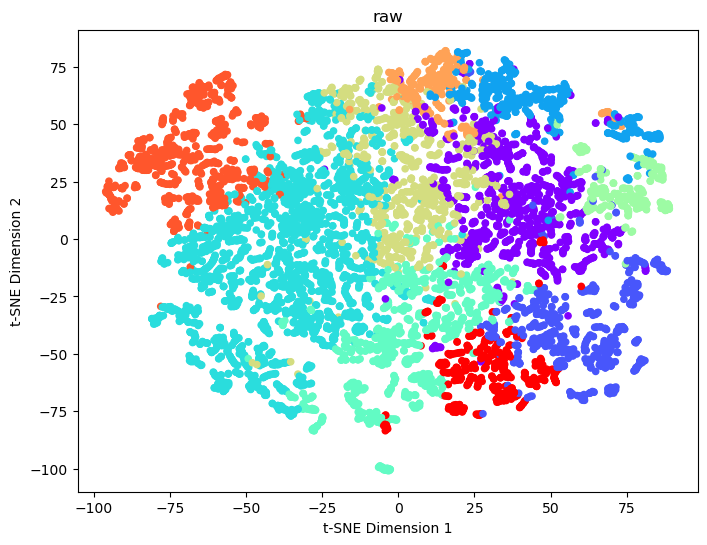

In [97]:
# plot TSNE graph
TSNEplots(x_train.to_numpy(),agg_10_clusters_labels,"raw") 

In [146]:
silhouetteScoreAllRaw = [] 
# for loop to obtain silhouette score with different numbers of clusters
#  Raw data
for i in range(2, 12): 
    # get labels with i number of clusters
    raw_labels_pred = aggfunc(x_train,i)
    # append score to list
    silhouetteScoreAllRaw.append(silhouetteScore(x_train,raw_labels_pred))

c:\Users\mujta\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Silhouette Score: 0.3532791090619684


c:\Users\mujta\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Silhouette Score: 0.1879831451772538


c:\Users\mujta\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Silhouette Score: 0.19888231502242126


c:\Users\mujta\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Silhouette Score: 0.20393837995988515


c:\Users\mujta\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Silhouette Score: 0.21153913098707894


c:\Users\mujta\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Silhouette Score: 0.1983724831499671


c:\Users\mujta\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Silhouette Score: 0.2006722206263219


c:\Users\mujta\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Silhouette Score: 0.0941067338452834


c:\Users\mujta\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Silhouette Score: 0.08563693469224311


c:\Users\mujta\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Silhouette Score: 0.08785947340116355


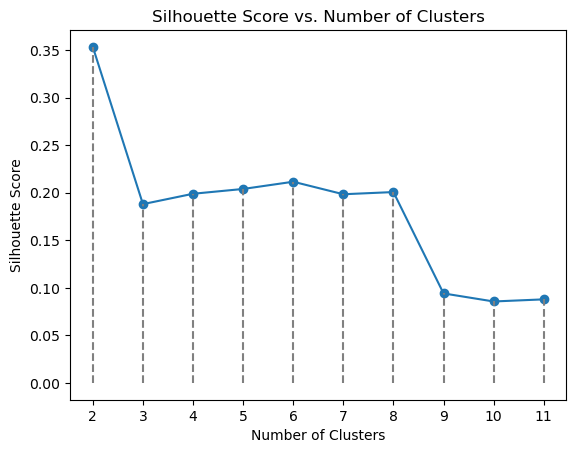

In [147]:
# Plot silhouette Scores against different number of clusters
# Raw data
cluster_range = range(2, 12)
plt.plot(cluster_range, silhouetteScoreAllRaw, marker='o')
plt.xticks(cluster_range)

for i in cluster_range:
    index = i - 2
    plt.plot([cluster_range[index], cluster_range[index]], [0, silhouetteScoreAllRaw[index]], linestyle='--', color='gray')


plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score vs. Number of Clusters')
plt.show()

In [33]:
# apply clustering algorithm to df converted to infrared with 10 clusters
agg_10_clusters_labels_infra = aggfunc(infrared_df_org,10)

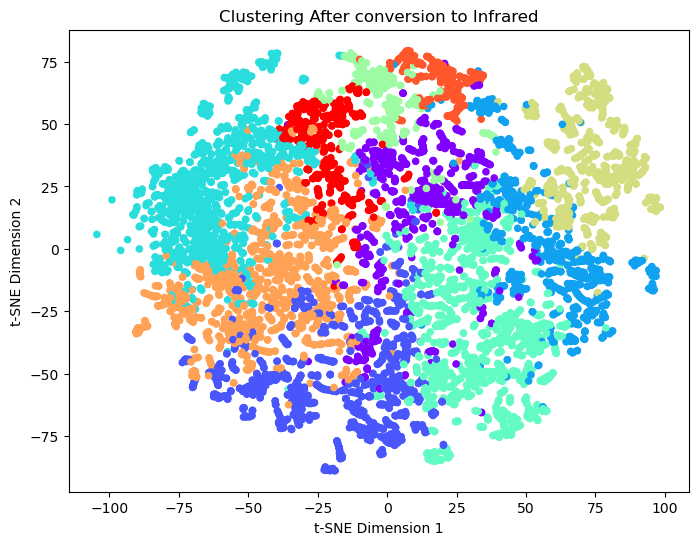

In [99]:
# plot TSNE graph
TSNEplots(infrared_df_org,agg_10_clusters_labels_infra,"Clustering After conversion to Infrared")

In [35]:
# obtain silhouette score
silhouetteScore(infrared_df_org,agg_10_clusters_labels_infra)

c:\Users\mujta\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Silhouette Score: 0.10424093019253086


In [36]:
# apply clustering algorithm to df converted to infrared and no outliers with 10 clusters
clusters_infra_no_outliers = aggfunc(infra_no_outliers, 10)
# obtain silhouette score
silhouetteScore(infra_no_outliers,clusters_infra_no_outliers)

c:\Users\mujta\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Silhouette Score: 0.08265232233522116


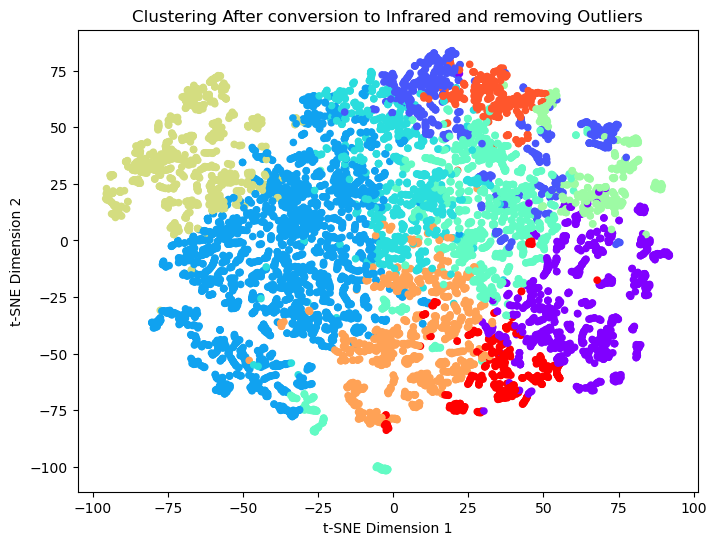

In [100]:
# plot TSNE graph
TSNEplots(infra_no_outliers,clusters_infra_no_outliers,"Clustering After conversion to Infrared and removing Outliers")

In [101]:
# apply Clustering After Normalisation with 10 clusters
clusters_infra_norm = aggfunc(infra_norm, 10)
# obtain silhouette score
silhouetteScore(infra_norm,clusters_infra_norm)

c:\Users\mujta\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Silhouette Score: 0.08682438504803372


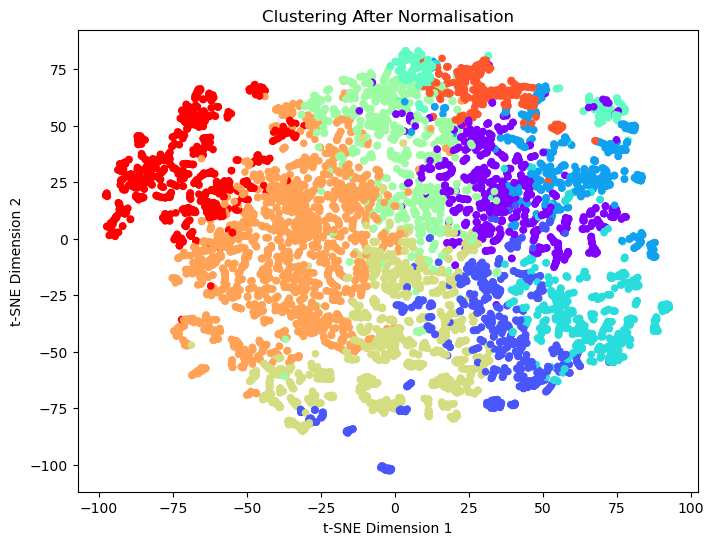

In [102]:
# plot TSNE graph
TSNEplots(infra_norm,clusters_infra_norm,"Clustering After Normalisation")

In [103]:
# apply Clustering After first normalising and then applying Infrared conversion with 10 clusters
clusters_infrared_df_norm = aggfunc(infrared_df_norm, 10)
# obtain silhouetteScore
silhouetteScore(infrared_df_norm,clusters_infrared_df_norm)

c:\Users\mujta\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Silhouette Score: 0.46254749032402126


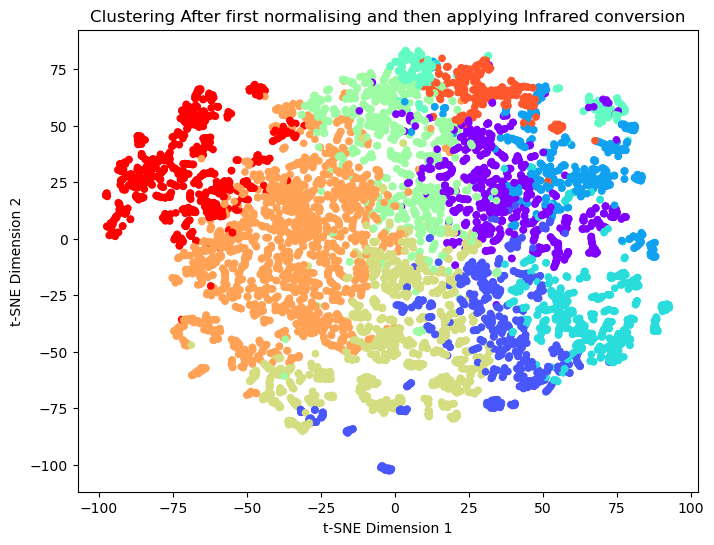

In [104]:
# plot TSNE graph
TSNEplots(infra_norm,clusters_infra_norm,"Clustering After first normalising and then applying Infrared conversion")

In [105]:
# Clustering After removing Outliers with 10 clusters
clusters_infra_norm_no_outliers = aggfunc(infra_norm_no_outliers, 10)
# obtain silhouette score
silhouetteScore(infra_norm_no_outliers,clusters_infra_norm_no_outliers)

c:\Users\mujta\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Silhouette Score: 0.46638652388869367


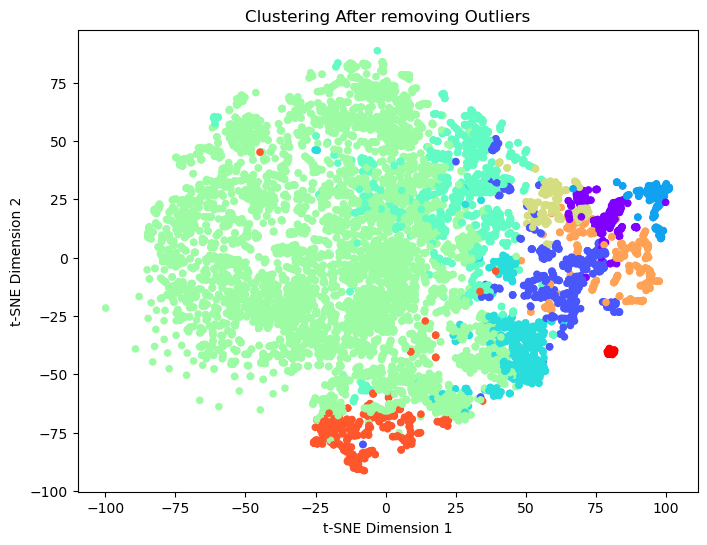

In [106]:
# plot TSNE graph
TSNEplots(infra_norm_no_outliers,clusters_infra_norm_no_outliers,"Clustering After removing Outliers")

In [128]:
silhouetteScoreAll = [] 
# for loop to obtain silhouette score with different numbers of clusters
# normalised and outlier mined data
for i in range(2, 15): 
    # get labels with i number of clusters
    clustersLabels = aggfunc(infra_norm_no_outliers,i)
    # append score to list
    silhouetteScoreAll.append(silhouetteScore(infra_norm_no_outliers,clustersLabels))



KeyboardInterrupt: 

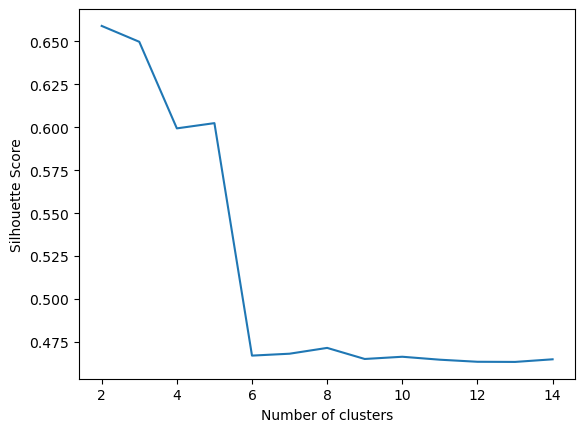

In [127]:
# Plot silhouette Scores against different number of clusters
plt.plot(range(2, 15), silhouetteScoreAll)
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score') 
plt.show()

In [108]:
# Clustering After removing Outliers with 2 clusters
clusters_infra_norm_no_outliers_2 = aggfunc(infra_norm_no_outliers, 2)
silhouetteScore(infra_norm_no_outliers,clusters_infra_norm_no_outliers_2)

c:\Users\mujta\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Silhouette Score: 0.658983680565739


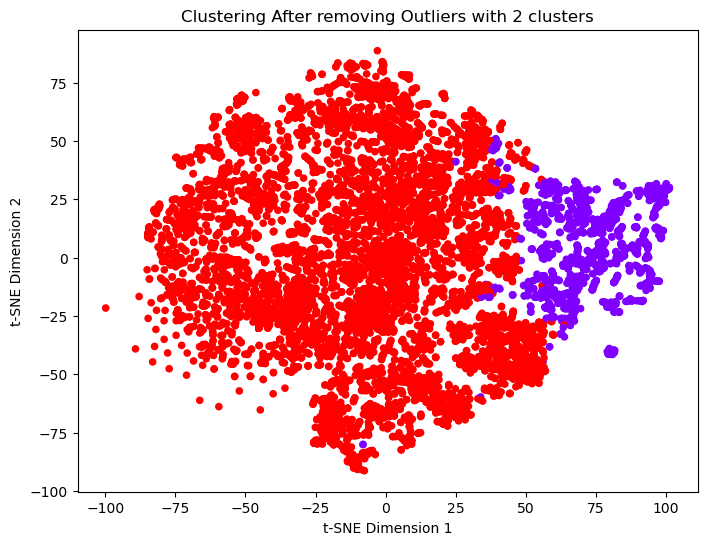

In [109]:
# plot graph
TSNEplots(infra_norm_no_outliers,clusters_infra_norm_no_outliers_2,"Clustering After removing Outliers with 2 clusters")

In [110]:
# Clustering After Preprocessing with 10 clusters
clusters_preprocessed = aggfunc(prepped_infrared_df, 10)
# obtain silhouetteScore
silhouetteScore(prepped_infrared_df,clusters_preprocessed)

c:\Users\mujta\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Silhouette Score: 0.44571711187269836


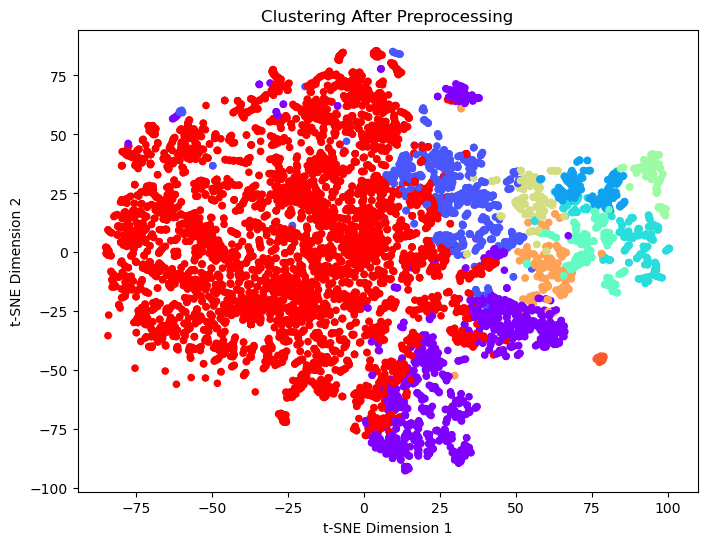

In [111]:
# plot graph
TSNEplots(prepped_infrared_df,clusters_preprocessed,"Clustering After Preprocessing")

In [112]:
# Clustering After Preprocessing (2 clusters)
clusters_preprocessed_2 = aggfunc(prepped_infrared_df, 2)
# obtain silhouetteScore
silhouetteScore(prepped_infrared_df,clusters_preprocessed_2)

c:\Users\mujta\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Silhouette Score: 0.6865004553787922


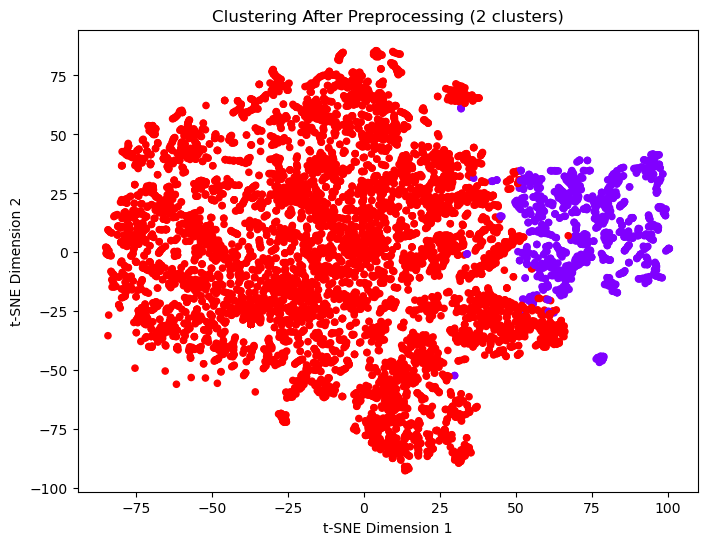

In [113]:
# plot graph
TSNEplots(prepped_infrared_df,clusters_preprocessed_2,"Clustering After Preprocessing (2 clusters)")

In [44]:
# apply pca on pre-processed data with 50 Components
df_pca_50 = PCAOnData(prepped_infrared_df, 50)
# apply clustering on df_pca_50 with 10 clusters
clusters_pca50 = aggfunc(df_pca_50, 10)
silhouetteScore(df_pca_50, clusters_pca50)

c:\Users\mujta\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Silhouette Score: 0.48610955106777737


In [46]:
# apply clustering on double processed data with 10 clusters
clusters = aggfunc(prepped_infrared_df2, 10)
silhouetteScore(prepped_infrared_df2, clusters)

c:\Users\mujta\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Silhouette Score: 0.786266646588159


In [47]:
# apply clustering on double processed data with 2 clusters
clusters = aggfunc(prepped_infrared_df, 2)
silhouetteScore(prepped_infrared_df, clusters)

c:\Users\mujta\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Silhouette Score: 0.6865004553787922


In [48]:
# apply pca on double pre-processed data with 50 Components
pca_50 = PCAOnData(prepped_infrared_df2, 50)

In [49]:
# apply clustering on pca_50 with 10 clusters and obtain silhouetteScore
clusters = aggfunc(pca_50, 10)
silhouetteScore(pca_50, clusters)

c:\Users\mujta\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Silhouette Score: 0.7872079356565395


In [50]:
# apply clustering on pca_50 with 5 clusters and obtain silhouetteScore
clusters = aggfunc(pca_50, 5)
silhouetteScore(pca_50, clusters)

c:\Users\mujta\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Silhouette Score: 0.7992193949794117


In [51]:
# apply pca on double pre-processed data with 3 Components
pca_3 = PCAOnData(prepped_infrared_df2,3)

In [52]:
# apply clustering on pca_3 with 2 clusters and obtain silhouetteScore
clusters = aggfunc(pca_50, 2)
silhouetteScore(pca_50, clusters)

c:\Users\mujta\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Silhouette Score: 0.8664894784735309


C:\Users\mujta\AppData\Local\Temp\ipykernel_9672\1976246888.py:8: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(dataTSNE[:, 0], dataTSNE[:, 1], c=clusterlabels,cmap="rainbow", s=20)


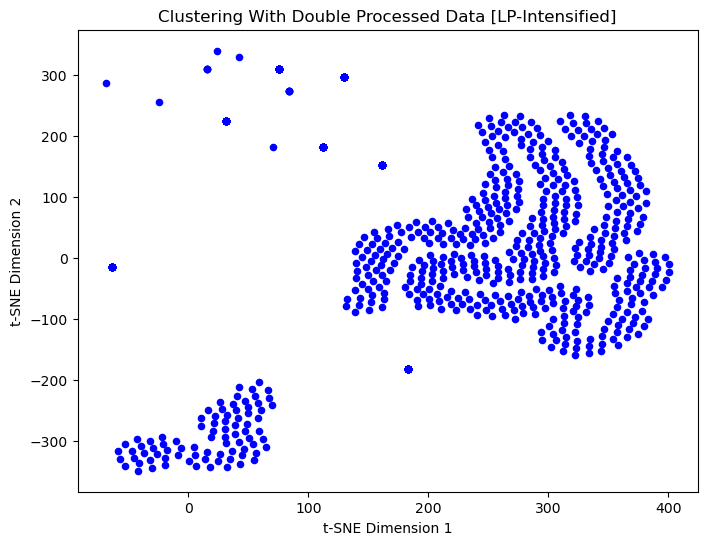

In [140]:
# plot T-SNE graph for Clustering With Double Processed Data [LP-Intensified]
TSNEplots(lower_frequency_data.copy(),'b',"Clustering With Double Processed Data [LP-Intensified]")

In [141]:
silhouetteScoreAll = [] 
# obtain silhouette Scores for final processed data by applying clustering for various number of clusters
lfd = lower_frequency_data.copy()
for i in range(2, 15): 
    
    clustersLabels = aggfunc(lfd,i)
    silhouetteScoreAll.append(silhouetteScore(lfd,clustersLabels))

c:\Users\mujta\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Silhouette Score: 0.8219683117859206


c:\Users\mujta\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Silhouette Score: 0.9559656747743789


c:\Users\mujta\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Silhouette Score: 0.9903732291634493


c:\Users\mujta\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Silhouette Score: 0.9708006803981317


c:\Users\mujta\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Silhouette Score: 0.9726766616035946


c:\Users\mujta\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Silhouette Score: 0.9696134690118321


c:\Users\mujta\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Silhouette Score: 0.9725839252383244


c:\Users\mujta\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Silhouette Score: 0.9724330022560203


c:\Users\mujta\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Silhouette Score: 0.972801141885017


c:\Users\mujta\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Silhouette Score: 0.9713207248331386


c:\Users\mujta\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Silhouette Score: 0.9712409332420776


c:\Users\mujta\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Silhouette Score: 0.9720436414574629


c:\Users\mujta\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Silhouette Score: 0.9720435678515499


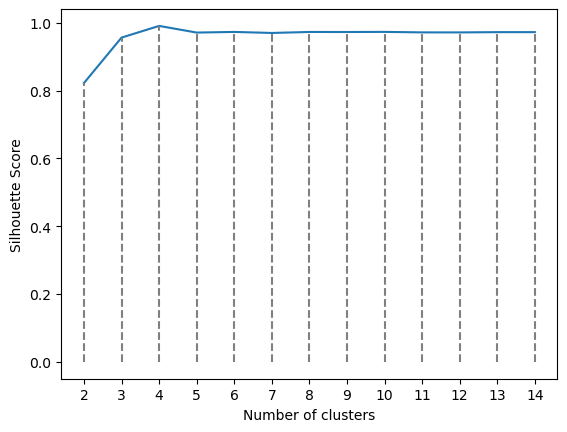

In [144]:
# plot comparison 
plt.plot(range(2, 15), silhouetteScoreAll)
plt.xticks(range(2, 15))
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score') 
clusterRange = range(2, 15)
for i in clusterRange:
    index = i - 2
    plt.plot([clusterRange[index], clusterRange[index]], [0, silhouetteScoreAll[index]], linestyle='--', color='gray')

plt.show()

In [134]:
# create copy iso_data
testing_df = iso_data.copy()
# remove outliers from y_train
y_train = pd.read_csv('CompleteDataSet/y_train_all.csv')
y_train = y_train.drop(outlier_indices)
y_train = np.asarray(y_train)
# apply clustering
cluster_labels = aggfunc(testing_df,10)


In [136]:
def accuracy_metric(testing_df, y_train, cluster_labels):
    data = []
    labels = []

    # Convert y_train to numpy array if it is a dataframe.

    if type(y_train) == pd.DataFrame:
        y_train_array = y_train.to_numpy()

    # Iterating through each cluster

    for cluster_label in np.unique(cluster_labels):
        
        # Getting the data points that belong to the current cluster by creating a boolean mask and 
        # applying it to our dataframe.

        cluster_mask = (cluster_labels == cluster_label)
        X_cluster = testing_df[cluster_mask]

        # Retrieving the corresponding ground truth labels from y_train.

        y_cluster = y_train_array[cluster_mask].flatten()

        # Appending the data points and labels to lists.

        data.append(X_cluster)
        labels.append(y_cluster)
    
    # Concatenating the lists into numpy arrays.

    data = np.concatenate(data, axis=0)
    labels = np.concatenate(labels)

    # Computing the accuracy score using the accuracy_score function from sklearn.
    
    accuracy = accuracy_score(y_train, labels)
    print("Accuracy:", accuracy)
    return accuracy

In [137]:
# get accuracy
accuracy= accuracy_metric(testing_df,y_train,cluster_labels)
accuracy

0.6569373501511518

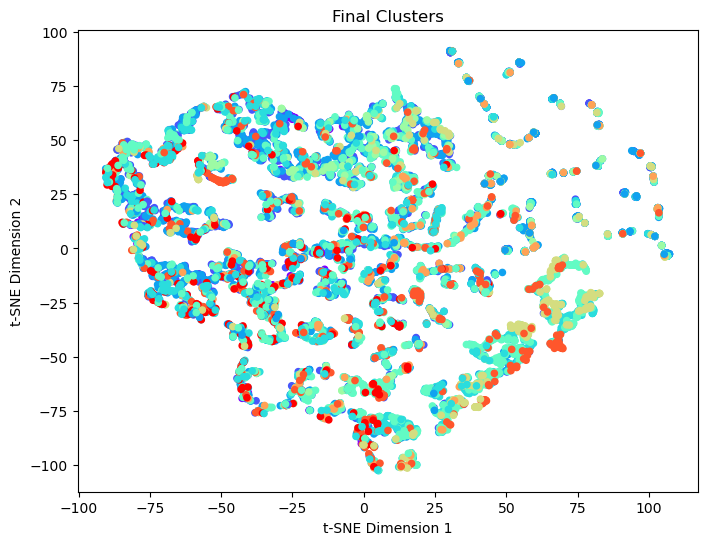

In [138]:
# plot TSNE graph
TSNEplots(testing_df,cluster_labels,"Final Clusters")

In [167]:
raw_scores = silhouetteScoreAllRaw[::2]
processed_scores = silhouetteScoreAll[::2]
silhouette_bf = [raw_scores,processed_scores[0:5]]


# Comparision

In [168]:
x_axis = ["Raw", "After Pre-processing"]
y_axis = ["2 Clusters", "4 Clusters", "6 Clusters", "8 Clusters", "10 Clusters"] 
pd.DataFrame(silhouette_bf, x_axis, y_axis)

,2 Clusters,4 Clusters,6 Clusters,8 Clusters,10 Clusters
Raw,0.353279,0.198882,0.211539,0.200672,0.085637
After Pre-processing,0.821968,0.990373,0.972677,0.972584,0.972801


# Birch Clustering

In [ ]:
from sklearn.cluster import Birch


In [ ]:
# function to apply Birch clustering on df
# takes df and num of clusters as parameters
# returns predicted labels
def birchfunc(data,n_clusters):
    brc = Birch(threshold=0.3, branching_factor=50,n_clusters=n_clusters)
    clusters = brc.fit_predict(data)
    clusters = pd.DataFrame(clusters)
    
    return clusters

In [ ]:
# infrared_df_norm = pd.read_csv("infrared_df_norm.csv")
# infra_norm_no_outliers = pd.read_csv("infra_norm_no_outliers.csv")
# prepped_infrared_df = pd.read_csv("prepped_infrared_df.csv")
# testing_df = pd.read_csv("testing_df.csv")
# infra_no_outliers = pd.read_csv('x_train_no_outliers.csv')
# infrared_df_org = pd.read_csv("infrared_df_org.csv")

In [ ]:
testing_df.shape

(9593, 3)

In [ ]:
# apply clustering algorithm to df with 10 clusters
birch_labels_raw = birchfunc(x_train,10)

In [ ]:
# obtain silhouette score
silhouetteScore(x_train,birch_labels_raw)

c:\Users\mujta\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Silhouette Score: 0.08563693469224311


0.08563693469224311

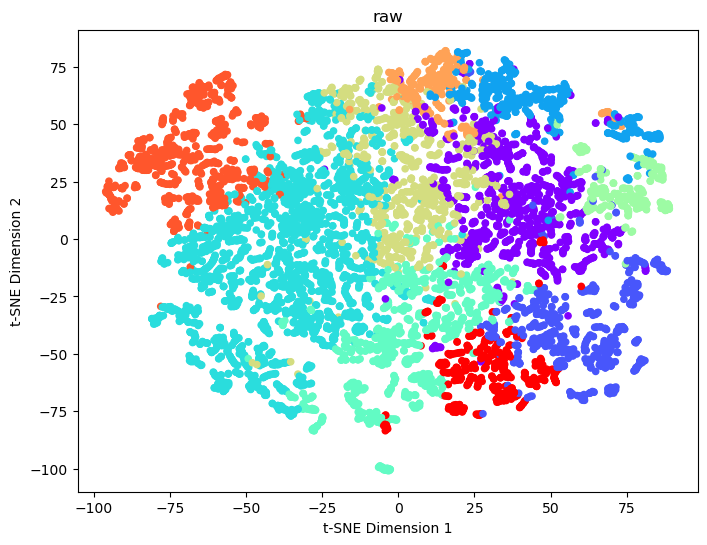

In [ ]:
# plot TSNE graph
TSNEplots(x_train.to_numpy(),birch_labels_raw,"raw")

In [ ]:
# apply clustering algorithm to df converted to infrared with 10 clusters
birch_labels_infra = birchfunc(infrared_df_org,10)

In [ ]:
# obtain silhouette score
silhouetteScore(infrared_df_org,birch_labels_infra)

c:\Users\mujta\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Silhouette Score: 0.14697351726416283


0.14697351726416283

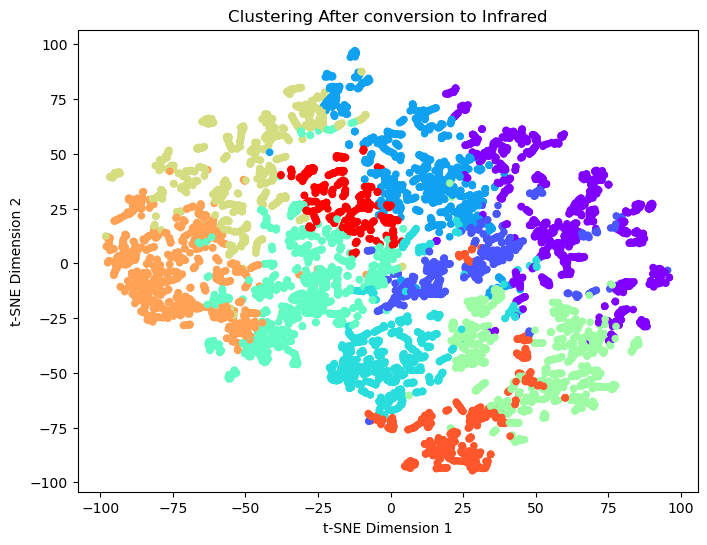

In [ ]:
# plot TSNE graph
TSNEplots(infrared_df_org,birch_labels_infra,"Clustering After conversion to Infrared")

In [ ]:
# apply clustering algorithm to df converted to infrared and no outliers with 10 clusters
birch_labels_infra_no_outliers = birchfunc(infra_no_outliers, 10)

In [ ]:
# obtain silhouette score
silhouetteScore(infra_no_outliers,birch_labels_infra_no_outliers)

c:\Users\mujta\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Silhouette Score: 0.08265232233522116


0.08265232233522116

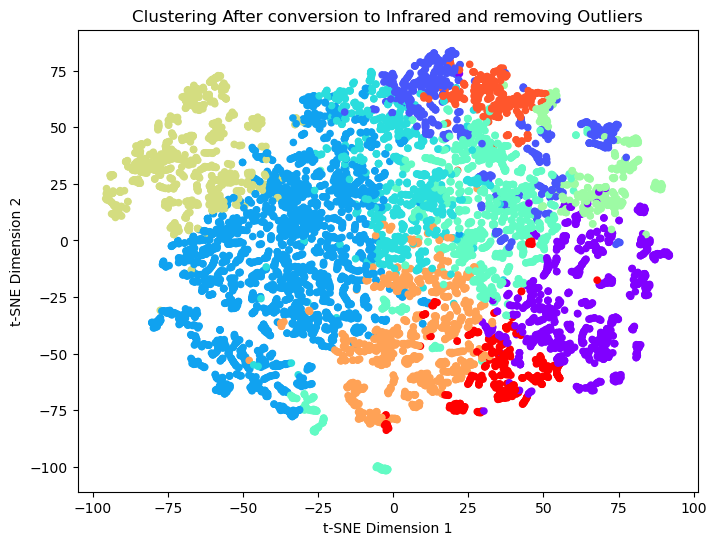

In [ ]:
# plot TSNE graph
TSNEplots(infra_no_outliers,birch_labels_infra_no_outliers,"Clustering After conversion to Infrared and removing Outliers")

In [ ]:
# apply Clustering After first normalising and then applying Infrared conversion with 10 clusters
birch_labels_infrared_df_norm = birchfunc(infrared_df_norm, 10)

In [ ]:
# obtain silhouetteScore
silhouetteScore(infrared_df_norm,birch_labels_infrared_df_norm)

c:\Users\mujta\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Silhouette Score: 0.29379717360568686


0.29379717360568686

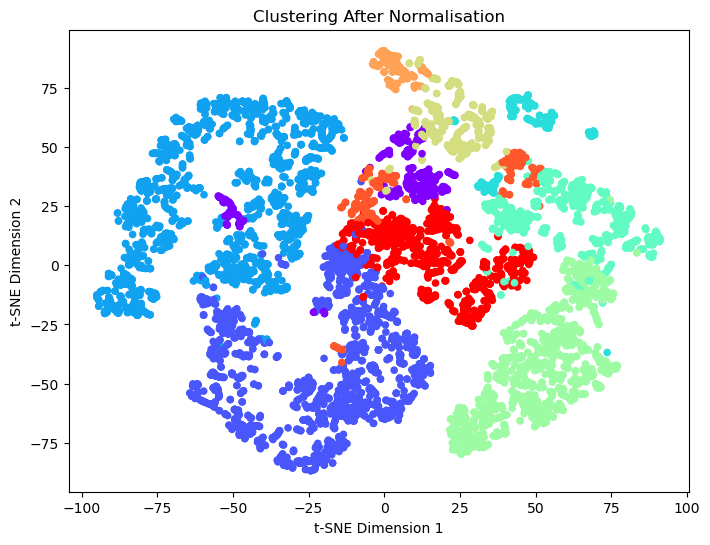

In [ ]:
# plot TSNE graph
TSNEplots(infrared_df_norm,birch_labels_infrared_df_norm,"Clustering After Normalisation")

In [ ]:
# Clustering After removing Outliers with 10 clusters
birch_labels_infrared_norm_no_outliers = birchfunc(infra_norm_no_outliers, 10)

In [ ]:
# obtain silhouette score
silhouetteScore(infra_norm_no_outliers,birch_labels_infrared_norm_no_outliers)

c:\Users\mujta\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Silhouette Score: 0.2908286104320689


0.2908286104320689

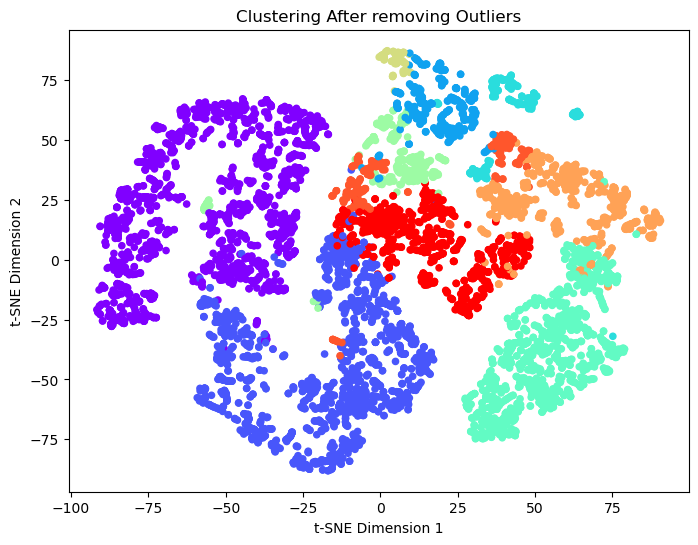

In [ ]:
# plot TSNE graph
TSNEplots(infra_norm_no_outliers,birch_labels_infrared_norm_no_outliers,"Clustering After removing Outliers")

In [ ]:
# Clustering After removing Outliers with 2 clusters
birch_infra_norm_no_outliers_2 = birchfunc(infra_norm_no_outliers, 2)


In [ ]:
# apply silhouetteScore
silhouetteScore(infra_norm_no_outliers,birch_infra_norm_no_outliers_2)

c:\Users\mujta\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Silhouette Score: 0.43155433416909283


0.43155433416909283

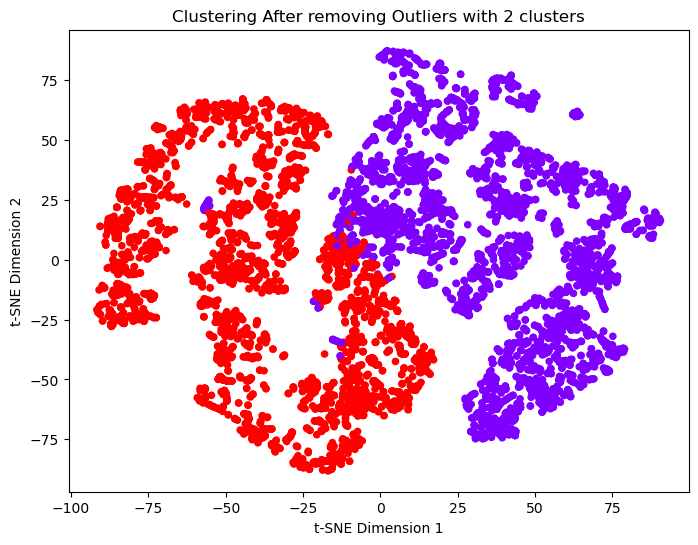

In [ ]:
# plot graph
TSNEplots(infra_norm_no_outliers,birch_infra_norm_no_outliers_2,"Clustering After removing Outliers with 2 clusters")

In [ ]:
# Clustering After Preprocessing with 10 clusters
birch_preprocessed = birchfunc(prepped_infrared_df, 10)


In [ ]:
# obtain silhouetteScore
silhouetteScore(prepped_infrared_df,birch_preprocessed)

c:\Users\mujta\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Silhouette Score: 0.2694771753718034


0.2694771753718034

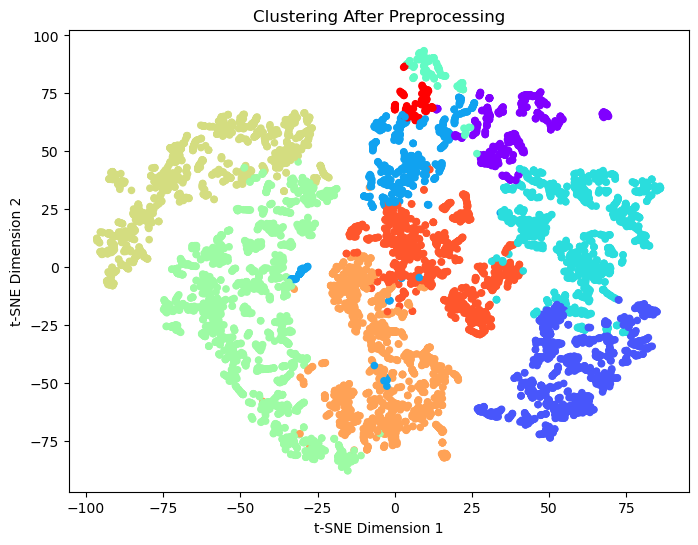

In [ ]:
# plot graph
TSNEplots(prepped_infrared_df,birch_preprocessed,"Clustering After Preprocessing")

In [ ]:
# Clustering After Preprocessing (2 clusters)
birch_preprocessed_2 = birchfunc(prepped_infrared_df, 2)


In [ ]:
# obtain silhouetteScore
silhouetteScore(prepped_infrared_df,birch_preprocessed_2)

c:\Users\mujta\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Silhouette Score: 0.3868445629754047


0.3868445629754047

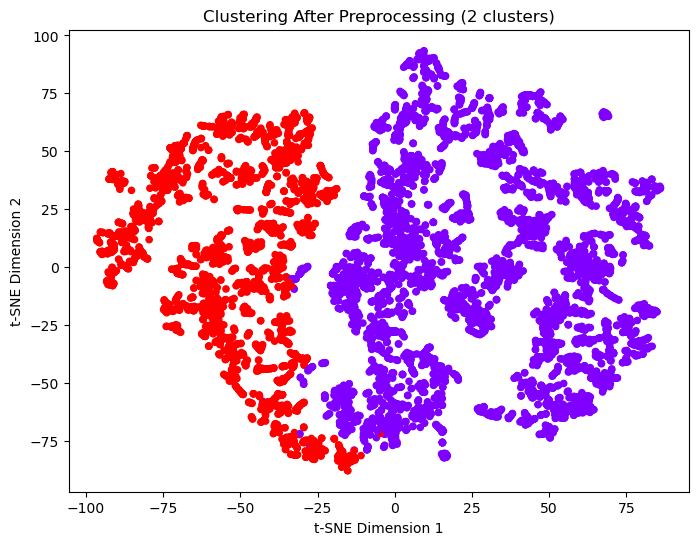

In [ ]:
# plot graph
TSNEplots(prepped_infrared_df,birch_preprocessed_2,"Clustering After Preprocessing (2 clusters)")

In [ ]:
# apply clustering to final df
birch_labels_final = birchfunc(testing_df,10)

In [ ]:
silhouetteScore(testing_df,birch_labels_final)

c:\Users\mujta\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Silhouette Score: 0.45358329187532015


0.45358329187532015

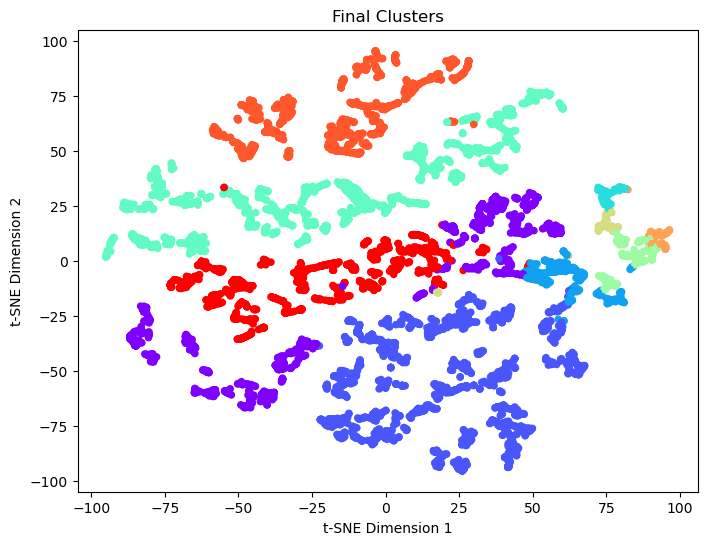

In [ ]:
# plot TSNE graph
TSNEplots(testing_df,birch_labels_final,"Final Clusters")


### Silhouette Scores

In [ ]:
silhouetteScoreAllRawBirch = [] 
# obtain silhouette Scores for raw data by applying clustering for various number of clusters
for i in range(2, 12): 
    raw_labels_pred = birchfunc(x_train,i)
    silhouetteScoreAllRawBirch.append(silhouetteScore(x_train,raw_labels_pred))

c:\Users\mujta\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Silhouette Score: 0.3532791090619684


c:\Users\mujta\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Silhouette Score: 0.1879831451772538


c:\Users\mujta\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Silhouette Score: 0.19888231502242126


c:\Users\mujta\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Silhouette Score: 0.20393837995988515


c:\Users\mujta\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Silhouette Score: 0.21153913098707894


c:\Users\mujta\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Silhouette Score: 0.1983724831499671


c:\Users\mujta\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Silhouette Score: 0.2006722206263219


c:\Users\mujta\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Silhouette Score: 0.0941067338452834


c:\Users\mujta\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Silhouette Score: 0.08563693469224311


c:\Users\mujta\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Silhouette Score: 0.08785947340116355


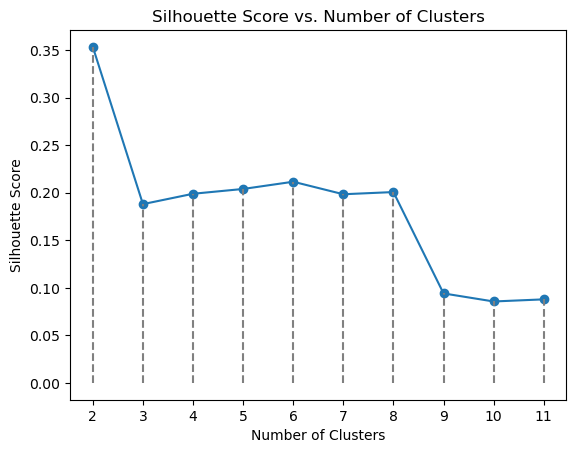

In [ ]:
# plot comparison graph

cluster_range = range(2, 12)
plt.plot(cluster_range, silhouetteScoreAllRawBirch, marker='o')
plt.xticks(cluster_range)

for i in cluster_range:
    index = i - 2
    plt.plot([cluster_range[index], cluster_range[index]], [0, silhouetteScoreAllRawBirch[index]], linestyle='--', color='gray')


plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score vs. Number of Clusters')
plt.show()

In [ ]:
silhouetteScoreAllFinalBirch = [] 
# obtain silhouette Scores for final processed data by applying clustering for various number of clusters
for i in range(2, 12): 
    final_labels_pred = birchfunc(testing_df,i)
    silhouetteScoreAllFinalBirch.append(silhouetteScore(testing_df,final_labels_pred))

c:\Users\mujta\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Silhouette Score: 0.7356461348732126


c:\Users\mujta\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Silhouette Score: 0.49740497820875224


c:\Users\mujta\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Silhouette Score: 0.5026851853104387


c:\Users\mujta\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Silhouette Score: 0.48859566431607565


c:\Users\mujta\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Silhouette Score: 0.515746183765349


c:\Users\mujta\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Silhouette Score: 0.5208769405849668


c:\Users\mujta\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Silhouette Score: 0.5210412926966709


c:\Users\mujta\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Silhouette Score: 0.4628274317091819


c:\Users\mujta\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Silhouette Score: 0.45358329187532015


c:\Users\mujta\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Silhouette Score: 0.45782399699704873


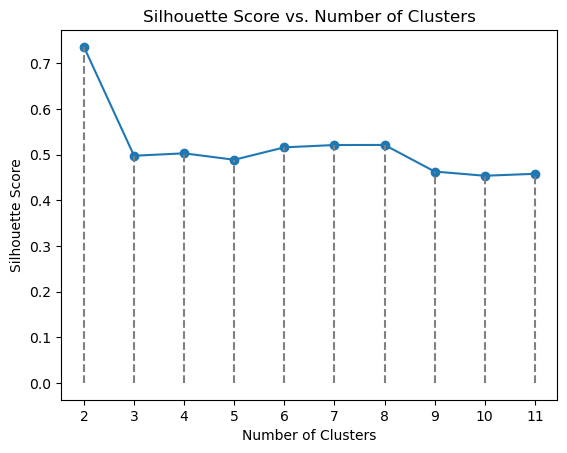

In [ ]:
# plot comparison graph

cluster_range = range(2, 12)
plt.plot(cluster_range, silhouetteScoreAllFinalBirch, marker='o')
plt.xticks(cluster_range)

for i in cluster_range:
    index = i - 2
    plt.plot([cluster_range[index], cluster_range[index]], [0, silhouetteScoreAllFinalBirch[index]], linestyle='--', color='gray')


plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score vs. Number of Clusters')
plt.show()

# Comparision

In [ ]:
raw_scores = silhouetteScoreAllRawBirch[::2]
processed_scores = silhouetteScoreAllFinalBirch[::2]
silhouette_bf = [raw_scores,processed_scores]

x_axis = ["Raw", "After Pre-processing"]
y_axis = ["2 Clusters", "4 Clusters", "6 Clusters", "8 Clusters", "10 Clusters"] 
pd.DataFrame(silhouette_bf, x_axis, y_axis)

,2 Clusters,4 Clusters,6 Clusters,8 Clusters,10 Clusters
Raw,0.353279,0.198882,0.211539,0.200672,0.085637
After Pre-processing,0.735646,0.502685,0.515746,0.521041,0.453583
